## Questions

Are students asking conceptual or appllied questions?
Which topics are more prevalent? Where is the most confusion?
    - Topic Modeling
    - Run the same topic model over different intervals of time
What do in-person interactions not already tell us? 
What are areas that need attention in student understanding? 
    - Concrete evidence of topics where students are struggling
Probably don't look at response time
What are people afraid of asking about? (Anonymous posts from students)
Data:
    - Timestamp
    - Userid (student or instructor, throw out announcements)
    - Question or answer? 
    - Votes (good question)
    - Question Text

    
diff values of config?
Check status = active
transform to get length of upvote_ids

Question or Answer? 
Num votes/good question
where does anon equal yes

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import random
from typing import List, Tuple

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 

In [2]:
dfs = glob.glob('data/dataframes/*.p')
dfs

['data/dataframes/kimia@live.unc.edu_posts_iqv0bsb3p2i3ch.p_dataframe_iqv0bsb3p2i3ch.p',
 'data/dataframes/lexokan@live.unc.edu_posts_j5wwaj87hvu6af.p_dataframe_j5wwaj87hvu6af.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jz8ejj1lawb5st.p_dataframe_jz8ejj1lawb5st.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jqnyuvgzug4p3.p_dataframe_jqnyuvgzug4p3.p',
 'data/dataframes/dupreezd@live.unc.edu_posts_jkws0l0gvcr7it.p_dataframe_jkws0l0gvcr7it.p']

In [31]:
# Are these the correct semesters for Danielle's classes? 
class_names = {
    0: 'Fall 2016',
    1: 'Fall 2017',
    2: '',
    3: 'Spring 2019',
    4: 'Fall 2019'
}

In [3]:
def print_topics(model, vectorizer, top_n: int=10)-> List: 
    """Print the top n words found by each topic model.
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of words you wish to return 
        
    Source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
    
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
    return [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        
def lda_operation(data_samples, num_features: int=400, num_topics: int=6)-> Tuple: 
    """Performs Latent Dirichlet Allocation on a list of our text samles 
    
    Args:
        data_samples List[str]: List of strings representing the text of each Piazza post
        num_features (int): Max number of features to be considered by term frequency
        num_topics (int): Number of topics 
    
    Returns:
        tuple: Trained LDA Model and the embedded text in the CountVectorizer
        
    """
    
    tf_vectorizer = CountVectorizer(max_df=.85, min_df=.05, max_features=num_features, stop_words='english', token_pattern=u'(?ui)\\b\\w\w*[a-z]+\\w*\\b')
    
    tf_data_samples = tf_vectorizer.fit_transform(data_samples) 
    tf_feature_names = tf_vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=100, learning_method='online', learning_offset=10.,random_state=1).fit(tf_data_samples)
    lda.score(tf_data_samples)

    return lda, tf_vectorizer

def save_topics(model, vectorizer, top_n: int=10)-> List:
    """ Save the top n topics from our trained model
    
    Args:
        model: Sklearn LatentDirichletAllocation model
        vectorizer: sklearn CountVectorizer
        top_n (int): Number of topics
    
    Returns:
        list: A list of the top_n words for each topic 
        
    """
    words_per_topic = []
    for idx, topic in enumerate(model.components_):
        words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n-1:-1]]
        words_per_topic.append(words)
    return words_per_topic

In [4]:
# Perform LDA on each of the COMP 401 classes
output = []
for i in range(len(dfs)):
    current_df = pd.read_pickle(dfs[i])
    data_list = current_df["text"].tolist()
    output.append(lda_operation(data_list))

In [5]:
# Save all of the words found by the topic model for each class
all_topic_words = []
for lda_output in output:
    print_topics(*lda_output)
    all_topic_words.append(save_topics(*lda_output))

Topic 0:
[('object', 473.245826992338), ('method', 473.06988484976887), ('public', 433.8483760124484), ('avatar', 78.17749343190209), ('java', 67.36342224356085), ('string', 66.7609407612646), ('class', 55.61240920126569), ('bridgescene', 33.97343062801197), ('command', 24.778752607343893), ('say', 19.168774769040773)]
Topic 1:
[('assignment', 116.36858741999418), ('just', 81.97489587814879), ('make', 70.77112726254455), ('credit', 67.60467982273158), ('extra', 63.10383472932928), ('property', 62.78977386938931), ('sure', 60.82801136661284), ('class', 55.26405864488635), ('checks', 50.37584092704761), ('way', 49.36150348276771)]
Topic 2:
[('class', 443.9362008266993), ('classes', 214.43269222771207), ('java', 189.0131904385507), ('test', 10.569191232160623), ('method', 5.8806429289638995), ('run', 4.062676352932096), ('checks', 1.6993494406814977), ('local', 1.214139489741465), ('sure', 0.9708629715729375), ('file', 0.9310635750805801)]
Topic 3:
[('java', 771.9682095591827), ('run', 53

In [6]:
all_text = [''.join(pd.read_pickle(df)["text"].tolist()) for df in dfs]
all_text = [re.sub(r'(?ui)\\b\\w\w*[a-z]+\\w*\\b', '', text) for text in all_text]

In [11]:
# all_text[0] has mostly java stack traces 
print(all_text[2])

 COMP 401 is holding a hackathon this semester!    For more details and to  register , visit:  https://401hackathon.weebly.com        #pin  Use this link to sign up for a cohort slot. Only sign up for 1 slot. If the time slot you want is full, put yourself on the waitlist.       https://docs.google.com/spreadsheets/d/1AcBjMXOupw8XXfZ05RNZZPXfVG_64n0wZEnGQdpVtSc/edit?usp=sharing       If there is no time slot that works for you, send Nikhil and I a message on Sakai.      #pin  For those of you without Sakai access yet (they will synch the rolls soon enough I believe), here is the A1 link:       http://www.cs.unc.edu/~kmp/comp401fall19/a1.html        #pin  PA.load("/dashboard/project_partners", null, function(data){ $('#' + 'questionText').html(data);});  #pin I&#39;m passing the JUnit test on Piazza but failed all of the jedi tests on Gradescope. Anyone has any ideas? Thanks a lot!  I thought I submitted to grade scope my code style assignment, however, it did not seem to fully upload i

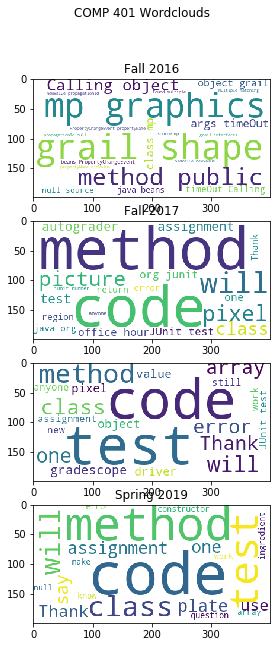

In [66]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 10))
fig.suptitle("COMP 401 Wordclouds")

for i in range(1, 5):
    wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
    wordcloud.generate(all_text[i-1])
    axs[i-1].set_title(class_names[i-1])
    axs[i-1].imshow(wordcloud)

In [8]:
# TODO: Distribution of document word counts 

In [ ]:
# TODO: t_SNE

In [ ]:
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/